<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据处理和特征构建" data-toc-modified-id="数据处理和特征构建-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据处理和特征构建</a></span><ul class="toc-item"><li><span><a href="#特征工程大致思路：" data-toc-modified-id="特征工程大致思路：-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>特征工程大致思路：</a></span></li><li><span><a href="#填充缺失值" data-toc-modified-id="填充缺失值-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>填充缺失值</a></span></li><li><span><a href="#查看变量分布" data-toc-modified-id="查看变量分布-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>查看变量分布</a></span></li><li><span><a href="#特征构造" data-toc-modified-id="特征构造-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>特征构造</a></span><ul class="toc-item"><li><span><a href="#聚合特征" data-toc-modified-id="聚合特征-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>聚合特征</a></span></li><li><span><a href="#双11相关特征" data-toc-modified-id="双11相关特征-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>双11相关特征</a></span></li></ul></li></ul></li><li><span><a href="#模型构建和训练&amp;评估" data-toc-modified-id="模型构建和训练&amp;评估-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>模型构建和训练&amp;评估</a></span><ul class="toc-item"><li><span><a href="#数据准备，评估函数准备" data-toc-modified-id="数据准备，评估函数准备-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>数据准备，评估函数准备</a></span></li><li><span><a href="#逻辑回归LR" data-toc-modified-id="逻辑回归LR-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>逻辑回归LR</a></span><ul class="toc-item"><li><span><a href="#原始数据" data-toc-modified-id="原始数据-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>原始数据</a></span></li><li><span><a href="#对样本作平衡处理" data-toc-modified-id="对样本作平衡处理-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>对样本作平衡处理</a></span></li></ul></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#MLP（tensorflow）" data-toc-modified-id="MLP（tensorflow）-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>MLP（tensorflow）</a></span></li></ul></li><li><span><a href="#最后输出预测结果" data-toc-modified-id="最后输出预测结果-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>最后输出预测结果</a></span></li><li><span><a href="#更多的讨论" data-toc-modified-id="更多的讨论-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>更多的讨论</a></span></li></ul></div>

天猫复购预测

写在最前面：

这个任务感觉需要在特征工程上多花心思，看了大家发布的notebook，感觉一些特征是有共性的，已经做的非常成熟了（eg：分类变量编码，点击率，渗透率等等）。

我的notebook中除了一些基础的特征构建，主要还会着眼于双11这个特殊时间节点的有关特征构造。

学习器采用了LR, LGB和MLP，判断标准是auc（看了一些notebook用分类准确率acc作为模型评估标准，显然是不可行的，因为样本严重不平衡，准确率可以轻松达到95%以上，但召回可能是0，用auc作为评价准则比较合理。）

# 数据处理和特征构建

## 特征工程大致思路：

>聚合特征：
>
>**toB:**  每个品类(或者其他unit)的销量/收藏量/加购量/点击量，渗透率
>
>**toC:**  这个人的总购买量/.../...，当天前一段时间内的购买量/.../...,

>活动辨识：
>
>是否双11（双十一的行为和之前会有很大差距）

>用户信息
>
>分类变量（Gender, age）的编码等


In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
user_info = pd.read_csv('./user_info_format1.csv')
user_log = pd.read_csv('./user_log_format_1.csv').rename(columns={'seller_id':'merchant_id'})

## 填充缺失值

In [3]:
#填充缺失值
user_info['gender'].fillna(2, inplace=True) #2和null都代表性别不确定
user_info['age_range'].fillna(-1, inplace=True)
user_log['brand_id'].fillna(-1, inplace=True)

## 查看变量分布
action type中大部分都是click，真正的购买行为很少

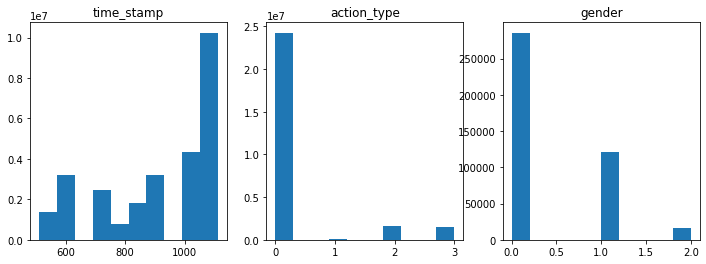

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(user_log['time_stamp']) #time_tamp 购买时间（格式：mmdd）
plt.title('time_stamp')
plt.subplot(1,3,2)
plt.hist(user_log['action_type'])
plt.title('action_type') #action_type包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹
plt.subplot(1,3,3)
plt.hist(user_info['gender']) #gender用户性别。0表示女性，1表示男性，2和NULL表示未知
plt.title('gender')
plt.show()

各种行为基本上都是在双十一激增，这一块的特殊性是有的挖的

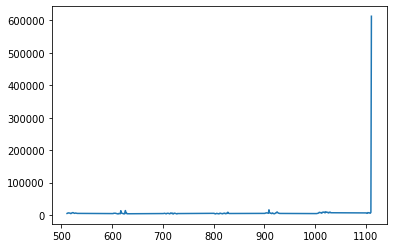

In [3]:
from matplotlib import pyplot as plt
plt.plot(user_log[user_log['action_type']==2].groupby('time_stamp').count()['action_type'])
plt.show()

## 特征构造
### 聚合特征

In [2]:
seller_group = user_log.groupby(["seller_id","action_type"]).count()[["user_id"]].reset_index().rename(columns={'user_id':'count'})
import gc
del user_log
gc.collect()

9

In [3]:
#seller_group = user_log.groupby(["seller_id","action_type"]).count()[["user_id"]].reset_index().rename(columns={'user_id':'count'})

#渗透率：
seller_feature = seller_group[seller_group['action_type']==0][['seller_id','count']].reset_index()[['seller_id','count']].rename(
    columns={'count':'click_count'})

def _get_action_cnt(num):
    seller_df = seller_group[seller_group['action_type']==num]
    cnt_list = []
    for i in seller_feature['seller_id']:
        l = list(seller_df['count'][seller_df['seller_id']==i])
        if l:
            cnt_list.append(l[0])
        else:
            cnt_list.append(0)
    return cnt_list
            
seller_feature['cart_count'] = _get_action_cnt(1)
seller_feature['sell_count'] = _get_action_cnt(2)
seller_feature['star_count'] = _get_action_cnt(3)
seller_feature.head()

,seller_id,click_count,cart_count,sell_count,star_count
0,1,160431,213,9187,6696
1,2,969,4,87,74
2,3,1212,1,25,78
3,4,1339,1,156,90
4,5,3762,4,87,290


In [6]:
train_df = train_df.merge(seller_feature,on="merchant_id",how='left').drop(['seller_id'],axis=1)
test_df = test_df.merge(seller_feature,on="merchant_id",how='left').drop(['seller_id'],axis=1)
train_df.to_csv('train_v1.csv', index=False)
test_df.to_csv('test_v1.csv',index=False)

In [2]:
train_df = pd.read_csv('./train_v1.csv')
test_df = pd.read_csv('./test_v1.csv')

### 双11相关特征

In [3]:
#都是新用户，就不用看action 2了
for i in (0,1,3):
    user_group = user_log[(user_log['time_stamp']<1111) & (user_log['action_type']==i)].groupby(
        ["user_id","merchant_id"]).count()[["action_type"]].reset_index()
    train_df = train_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}'.format(i)})
    test_df = test_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}'.format(i)})



In [4]:
for i in (0,1,3):
    user_group = user_log[(user_log['time_stamp']==1111) & (user_log['action_type']==i)].groupby(
        ["user_id","merchant_id"]).count()[["action_type"]].reset_index()
    train_df = train_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}_in1111'.format(i)})
    test_df = test_df.merge(user_group, on=['user_id','merchant_id'],how='left').rename(
        columns={'action_type':'action_type{}_in1111'.format(i)})

In [5]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [6]:
for i in (0,1,3):
    train_df['action{}_rate'.format(i)] = train_df.apply(lambda x:x['action_type{}_in1111'.format(i)]/x['action_type{}'.format(i)] if x['action_type{}'.format(i)]>0 else -1, axis=1)
    test_df['action{}_rate'.format(i)] = test_df.apply(lambda x:x['action_type{}_in1111'.format(i)]/x['action_type{}'.format(i)] if x['action_type{}'.format(i)]>0 else -1, axis=1)

In [8]:
train_df.to_csv('./train_v2.csv')
test_df.to_csv('./test_v2.csv')

# 模型构建和训练&评估
这一part在训练模型的时候，一定一定要考虑样本的不平衡问题！！！

## 数据准备，评估函数准备

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import lightgbm as lgb

x = train_df.drop(['user_id','merchant_id','label'],axis=1)
y = train_df['label']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 42)

In [3]:
from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(y_test, y_score):
    fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color='black', lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()


## 逻辑回归LR
### 原始数据

模型的评估报告：
              precision    recall  f1-score   support

        0.0       0.94      1.00      0.97     73518
        1.0       0.20      0.00      0.00      4742

avg / total       0.89      0.94      0.91     78260



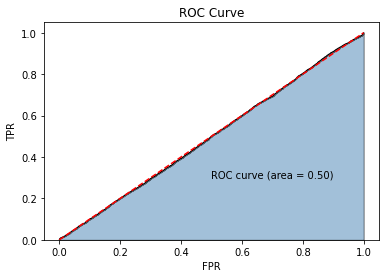

In [19]:
#数据不平衡，recall很差
lr = LogisticRegression(solver='liblinear')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_val)
lr_proba = lr.predict_proba(x_val)
print('模型的评估报告：\n',classification_report(y_val, lr_pred))
plot_roc(y_val, lr_proba[:,1])

### 对样本作平衡处理
调整了一下权重之后效果好多了

模型的评估报告：
              precision    recall  f1-score   support

        0.0       0.96      0.70      0.81     73518
        1.0       0.10      0.50      0.17      4742

avg / total       0.90      0.69      0.77     78260



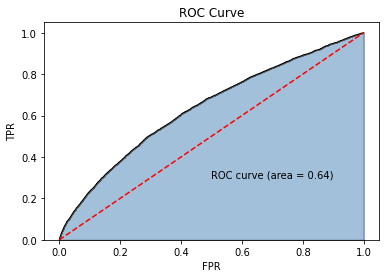

In [21]:
#balance一下
lr = LogisticRegression(solver='liblinear',class_weight='balanced')
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_val)
lr_proba = lr.predict_proba(x_val)
print('模型的评估报告：\n',classification_report(y_val, lr_pred))
plot_roc(y_val, lr_proba[:,1])

## LightGBM

In [ ]:
params = {
        'verbose':0,
        'min_data_in_leaf': 4,
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 32,
        'n_estimators':2000,
        #'max_bin': 50,
        'max_depth':5,
        "learning_rate": 0.01,
        "colsample_bytree": 0.8,  # 每次迭代中随机选择特征的比例
        "bagging_fraction": 0.8,  # 每次迭代时用的数据比例
        'n_jobs': -1,
        'silent': 1,  # 信息输出设置成1则没有信息输出
        'seed': 42,
        'bagging_freq':3,
        'is_unbalance':True,
        #'scale_pos_weight': wt
    }  #设置出参数

gbm = lgb.LGBMClassifier(**params)
gbm.fit(x_train, y_train, 
            eval_metric='auc',
    eval_set=[(x_train, y_train), (x_val, y_val)],
        early_stopping_rounds=30)
gbm_pred = gbm.predict(x_val)
gbm_proba = gbm.predict_proba(x_val)
print('模型的评估报告：\n',classification_report(y_val, gbm_pred))
plot_roc(y_val, gbm_proba[:,1])

模型的评估报告：
               precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     49026
         1.0       0.11      0.56      0.19      3147

   micro avg       0.71      0.71      0.71     52173
   macro avg       0.54      0.64      0.50     52173
weighted avg       0.91      0.71      0.78     52173



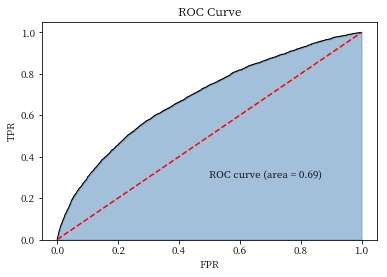

In [12]:
print('模型的评估报告：\n',classification_report(y_val, gbm_pred))
plot_roc(y_val, gbm_proba[:,1])

## MLP（tensorflow）

In [1]:
import numpy as np
np.random.seed(42)
#import tensorflow.compat.v1 as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop,Adam
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [18]:
x = train_df.drop(['user_id','merchant_id','label'],axis=1)
y = train_df['label']

In [15]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [16]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [31]:
from tensorflow.keras.optimizers import Adam

model = Sequential(name="MLP0")

#全连接
model.add(Dense(input_dim=56, units=128,activation='relu',name='fc1'))
model.add(BatchNormalization(name='bn1'))
model.add(Dropout(0.3,name='drpout1'))
model.add(Dense(256, activation='relu',name='fc2'))
model.add(BatchNormalization(name='bn2'))
model.add(Dropout(0.3,name='drpout2'))
#最后的输出层
model.add(Dense(1, activation='sigmoid',name='output'))

print(model.summary())
"""
把参数都写在最前面是一个好习惯
"""
epoch = 50 
batch_size = 128
learning_rate = 0.01
decay_rate = learning_rate / epoch
#momentum = 0.8
adam_optimizer = Adam(learning_rate=0.01,decay=decay_rate) #自定义优化器
from tensorflow.keras.callbacks import EarlyStopping
#monitor:监视参数,min_delta:小于此数认为不变化，mode:loss小好，acc大好，patience:n周期无提升则退出，restore_best_weights:取最优权重
earlyStop = EarlyStopping(monitor='val_auc', min_delta=1e-6, patience=4, mode='max', verbose=1, restore_best_weights = True)
#增加validation_data参数作为验证集，添加早停止机制，训练时打乱序列顺序
#model.fit(x_train, y_train, callbacks=[earlyStop],  epochs=10, batch_size=32, validation_split=0.1, verbose = 1,shuffle=True)

model.compile(optimizer = adam_optimizer,
             loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(curve='ROC', name = 'auc')]
             )

model.fit(x, y, epochs = epoch, callbacks=[earlyStop],class_weight={0:1,1:15},batch_size=batch_size, validation_split=0.1, verbose = 1,shuffle=True)

#loss, accuracy = model.evaluate(x_test, y_test)
#print('test loss:{}\t'.format(loss),'\ntest accuracy:{}'.format(accuracy))

Model: "MLP0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 128)               7296      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 128)               512       
_________________________________________________________________
drpout1 (Dropout)            (None, 128)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 256)               33024     
_________________________________________________________________
bn2 (BatchNormalization)     (None, 256)               1024      
_________________________________________________________________
drpout2 (Dropout)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 257    

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

x = train_df.drop(['user_id','merchant_id','label'],axis=1)
y = train_df['label']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 42)

from sklearn import metrics
from matplotlib import pyplot as plt

def plot_roc(y_test, y_score):
    fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
    plt.plot(fpr, tpr, color='black', lw = 1)
    plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
    plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.show()


In [21]:
mlp_proba = model.predict(x_val)

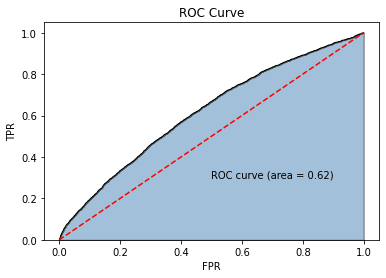

In [23]:
#print('模型的评估报告：\n',classification_report(y_val, gbm_pred))
plot_roc(y_val, mlp_proba)

# 最后输出预测结果
用了LightGBM的结果

In [ ]:
prob = gbm.predict_proba(test_df.drop(['user_id','merchant_id'],axis=1))
test_df['prob'] = pd.Series(prob[:,1])
test_df[['user_id, merchant_id','prob']].to_csv('prediction.csv')

In [1]:
pred = pd.read_csv('prediction.csv')
pred.head()

,user_id,merchant_id,prob
0,163968,4605,0.481369
1,360576,1581,0.597549
2,98688,1964,0.417265
3,98688,3645,0.295443
4,295296,3361,0.545527


# 更多的讨论
这个模型只是简单的把整个流程从头到尾走了一遍，虽然比较完整但还是有很多可以改进的地方，比如：

特征构建部分没有考虑之前有购买行为的顾客（虽然这部分并不需要预测），这部分数据是不是可以利用起来？

树模型的参数调整，是不是可以用一下交叉验证之类的方法？

神经网络是不是可以考虑更复杂的模型？

这些问题现在mark一下，有时间再继续更吧qwq，吃饭去了